# Datos desbalanceados

por Alejandro Correa Bahnsen y Jesus Solano

adaptado por Mónica Tatiana Gutierrez Ballen

version 2.0, Agosto 2021

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Rick Muller](http://www.cs.sandia.gov/~rmuller/), Sandia National Laboratories

## Antecedentes

Los problemas de clasificación desequilibrada causan problemas a muchos algoritmos de aprendizaje. Estos problemas se caracterizan por la proporción desigual de casos disponibles para cada clase del problema.

La mayoría de los algoritmos de clasificación sólo tienen un rendimiento óptimo cuando el número de muestras de cada clase es aproximadamente el mismo. Los conjuntos de datos muy sesgados, en los que la minoría supera ampliamente a una o más clases, han demostrado ser un reto y, al mismo tiempo, son cada vez más comunes.

Una forma de abordar este problema es remuestrear el conjunto de datos para compensar este desequilibrio con la esperanza de llegar a un límite de decisión más sólido y justo que el que se obtendría de otro modo.

Las técnicas de remuestreo se dividen en dos categorías: 
* Submuestreo de la(s) clase(s) mayoritaria(s)
* Sobremuestreo de la clase minoritaria


In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
plt.style.use('ggplot')

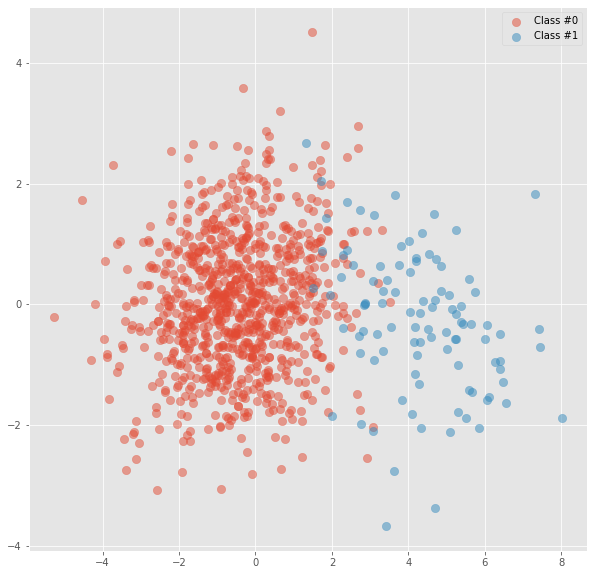

In [2]:

# Generar datos aleatorios
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.9, 0.1],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=1000, random_state=11)

# Instanciar un objeto PCA para facilitar su visualización
pca = PCA(n_components = 2)

# Ajustar y transformar x para visualizar dentro de un espacio de características 2D
x_vis = pca.fit_transform(X)

# Visualizar los datos originales

def plot_two_classes(X, y, subplot=False, size=(10, 10)):
    # Visualizar las dos clases
    if subplot == False:
        fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=size)
        
    subplot.scatter(X[y==0, 0], X[y==0, 1], label="Class #0", 
                    alpha=0.5, s=70)
    subplot.scatter(X[y==1, 0], X[y==1, 1], label="Class #1", 
                    alpha=0.5, s=70)
    subplot.legend()
    return subplot

plot_two_classes(x_vis, y)

In [3]:
print("Media para observar el desequilibrio:",y.mean())
print("Tamaño de los datos:",y.shape)

Media para observar el desequilibrio: 0.1
Tamaño de los datos: (1000,)


# Parte 1: Submuestreo

## Aleatorio - Submuestreo
Seleccione al azar un porcentaje de la clase negativa de forma que el conjunto de datos resultante esté equilibrado

In [4]:
n_samples = y.shape[0]
print(n_samples)

1000


In [5]:
n_samples_0 = (y == 0).sum()
n_samples_0

900

In [6]:
n_samples_1 = (y == 1).sum()
n_samples_1

100

In [7]:
n_samples_1 / n_samples

0.1

¿Cuántos casos negativos debo seleccionar si quiero un nuevo conjunto de datos con un 50% de positivos?

0,5 = n_muestras_1 / (n_muestras_1 + n_muestras_0_nuevas)

(n_muestras_1 + n_muestras_0_nuevas) = n_muestras_1 / 0,5

In [8]:
n_samples_0_new =  n_samples_1 / 0.5 - n_samples_1
n_samples_0_new

100.0

In [9]:
n_samples_0_new_per = n_samples_0_new / n_samples_0
n_samples_0_new_per

0.1111111111111111

Crear un filtro para seleccionar `n_muestras_0_nuevas_por` de la clase negativa

In [10]:
# Seleccionar todos los negativos
filter_ = y == 0

# Muestra aleatoria
np.random.seed(42)
rand_1 = np.random.binomial(n=1, p=n_samples_0_new_per, size=n_samples)

# Combinar
filter_ = filter_ & rand_1

In [11]:
filter_.sum()

109

Seleccione también todos los positivos

In [12]:
filter_ = filter_ | (y == 1)

In [13]:
filter_ = filter_.astype(bool)
filter_.sum()

209

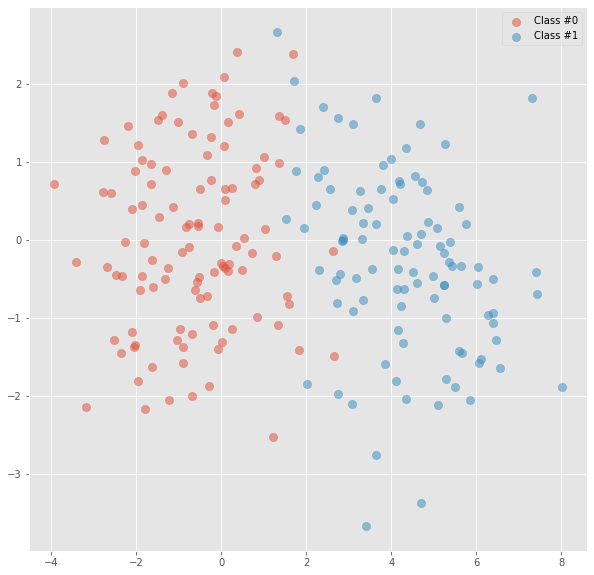

In [14]:
plot_two_classes(x_vis[filter_], y[filter_])

Convertir en una función

In [15]:
def UnderSampling(X, y, target_percentage=0.5, seed=None):
    # Asumiendo que la clase minoritaria es la positiva
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()

    n_samples_0_new =  n_samples_1 / target_percentage - n_samples_1
    n_samples_0_new_per = n_samples_0_new / n_samples_0

    filter_ = y == 0

    np.random.seed(seed)
    rand_1 = np.random.binomial(n=1, p=n_samples_0_new_per, size=n_samples)
    
    filter_ = filter_ & rand_1
    filter_ = filter_ | (y == 1)
    filter_ = filter_.astype(bool)
    
    return X[filter_], y[filter_]

Target percentage 0.1
y.shape =  1000 y.mean() =  0.1


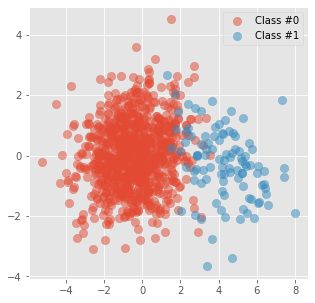

Target percentage 0.2
y.shape =  501 y.mean() =  0.1996007984031936


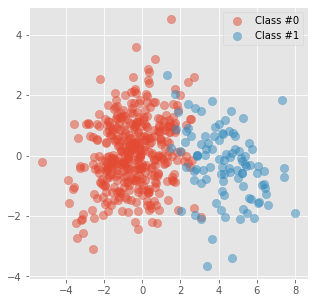

Target percentage 0.3
y.shape =  337 y.mean() =  0.29673590504451036


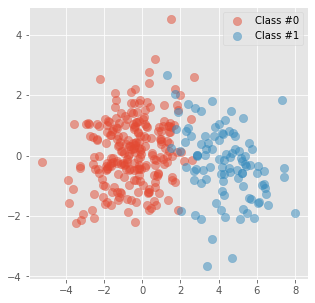

Target percentage 0.4
y.shape =  250 y.mean() =  0.4


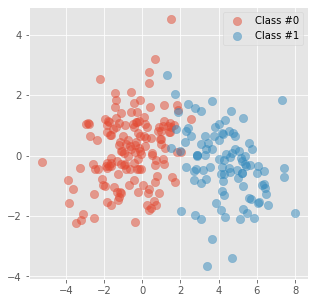

Target percentage 0.5
y.shape =  201 y.mean() =  0.4975124378109453


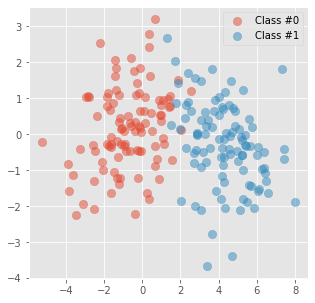

In [16]:
for target_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
    X_u, y_u = UnderSampling(x_vis, y, target_percentage, 1)
    print('Target percentage', target_percentage)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()    

### Comparación del submuestreo con otros modelos

**Ventajas del submuestreo:**

- Rápido de estimar
- Fácil de entender

**Desventajas del submuestreo:**

- Se pierde información de la clase negativa
- Varianza debida a la aleatoriedad 
- Necesidad de definir el porcentaje objetivo

## TomekLinks

Identificar y eliminar las muestras mayoritarias que forman un enlace Tomek con las muestras minoritarias.


Encontrar el vecino más cercano de cada punto

In [17]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2)
nn.fit(x_vis)
nns = nn.kneighbors(x_vis, return_distance=False)[:, 1]

In [18]:
nns[0:10]

array([491, 143, 137, 682,  25, 104, 749,  42, 883, 219])

Utiliza el vector objetivo y el primer vecino de cada muestra y busca los pares Tomek. Devuelve un vector booleano con True para los enlaces Tomek mayoritarios.

In [19]:
# Inicializar el resultado booleano como falso, y también un contador
links = np.zeros(len(y), dtype=bool)

# Se recorre cada muestra de la clase mayoritaria y se mira su primer vecino.
# Si su vecino más cercano también tiene la muestra actual como su vecino más cercano, los dos forman un enlace Tomek.
for ind, ele in enumerate(y):

    if ele == 1 | links[ind] == True:  # Mantener a todos los de la clase minoritaria
        continue

    if y[nns[ind]] == 1:

        # Si forman un enlace tomek, pon un marcador de Verdadero en esta muestra, y aumenta el contador en uno.
        if nns[nns[ind]] == ind:
            links[ind] = True


In [20]:
links.sum()

12

In [21]:
filter_ = np.logical_not(links)

y.shape =  988 y.mean() =  0.10121457489878542


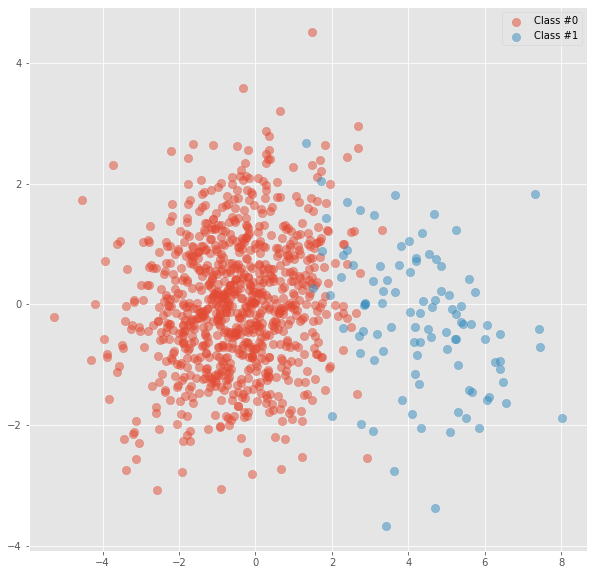

In [22]:
print('y.shape = ',y[filter_].shape[0], 'y.mean() = ', y[filter_].mean())
plot_two_classes(x_vis[filter_], y[filter_])

### Comparación de TomekLinks con otros modelos

**Ventajas de TomekLinks:**

- Crea un espacio linealmente separable

**Desventajas de TomekLinks:**

- Sigue siendo un conjunto de datos muy desequilibrado

## Vecino más cercano condensado

El objetivo es eliminar los ejemplos de la clase mayoritaria que están mucho más lejos de la frontera

In [23]:
# Importar el clasificador K-NN
from sklearn.neighbors import KNeighborsClassifier

In [24]:
# Número de muestras a extraer para construir el conjunto S.
n_seeds_S = 51

# Tamaño de la vecindad a considerar para calcular la 
# distancia media a las muestras de puntos minoritarios.
size_ngh = 100

# Obtenga al azar una muestra de la clase mayoritaria
np.random.seed(42)
maj_sample = np.random.choice(x_vis[y == 0].shape[0], n_seeds_S)
maj_sample = x_vis[y == 0][maj_sample]

In [25]:
# Crear el conjunto C
# Seleccionar todos los positivos y los negativos seleccionados al azar
C_x = np.append(x_vis[y == 1], maj_sample, axis=0)
C_y = np.append(y[y == 1], [0] * n_seeds_S)

In [26]:
# Crear el conjunto S
S_x = x_vis[y == 0]
S_y = y[y == 0]

In [27]:
knn = KNeighborsClassifier(n_neighbors=size_ngh)

# Encajar C en la knn
knn.fit(C_x, C_y)

# Clasificar en S
pred_S_y = knn.predict(S_x)

In [28]:
# Encuentra el S_y mal clasificado
idx_tmp = np.nonzero(y == 0)[0][np.nonzero(pred_S_y != S_y)]

In [29]:
filter_ = np.nonzero(y == 1)[0]
filter_ = np.concatenate((filter_, idx_tmp), axis=0)

y.shape =  328 y.mean() =  0.3048780487804878


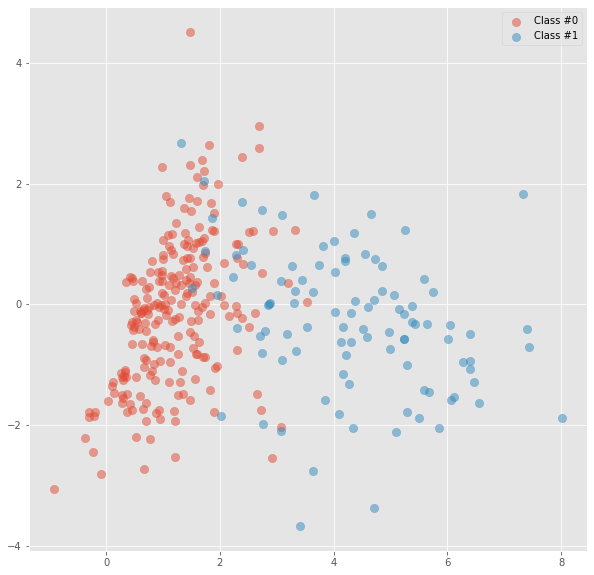

In [30]:
print('y.shape = ',y[filter_].shape[0], 'y.mean() = ', y[filter_].mean())
plot_two_classes(x_vis[filter_], y[filter_])

In [31]:
# Importar el clasificador K-NN
from sklearn.neighbors import KNeighborsClassifier
def CondensedNearestNeighbor(X, y, n_seeds_S=1, size_ngh=1, seed=None):
    # Obtenga al azar una muestra de la clase mayoritaria
    np.random.seed(seed)
    maj_sample = np.random.choice(X[y == 0].shape[0], n_seeds_S)
    maj_sample = X[y == 0][maj_sample]
    # Crear el conjunto C
    # Seleccionar todos los positivos y los negativos seleccionados al azar
    C_x = np.append(X[y == 1], maj_sample, axis=0)
    C_y = np.append(y[y == 1], [0] * n_seeds_S)
    # Crear el conjunto S
    S_x = X[y == 0]
    S_y = y[y == 0]
    knn = KNeighborsClassifier(n_neighbors=size_ngh)

    # Encajar C en la knn
    knn.fit(C_x, C_y)

    # Clasificar en S
    pred_S_y = knn.predict(S_x)
    # Encuentra el S_y mal clasificado
    idx_tmp = np.nonzero(y == 0)[0][np.nonzero(pred_S_y != S_y)]

    filter_ = np.nonzero(y == 1)[0]
    filter_ = np.concatenate((filter_, idx_tmp), axis=0)

    return X[filter_], y[filter_]

n_seeds_S  1 size_ngh  1
y.shape =  377 y.mean() =  0.26525198938992045


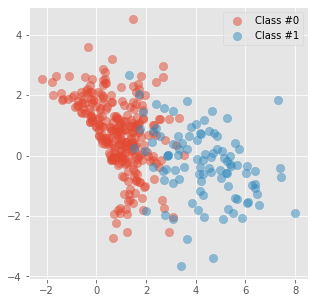

n_seeds_S  100 size_ngh  100
y.shape =  131 y.mean() =  0.7633587786259542


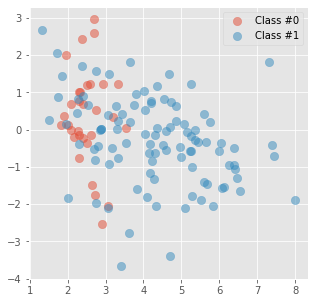

n_seeds_S  50 size_ngh  50
y.shape =  196 y.mean() =  0.5102040816326531


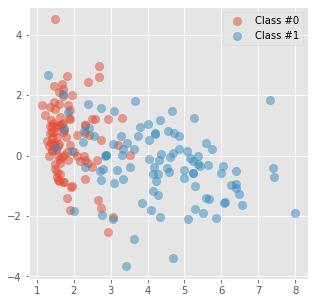

n_seeds_S  100 size_ngh  50
y.shape =  140 y.mean() =  0.7142857142857143


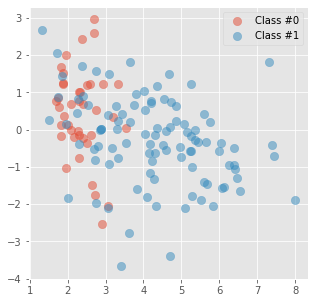

n_seeds_S  50 size_ngh  100
y.shape =  385 y.mean() =  0.2597402597402597


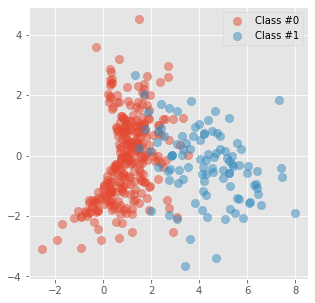

In [32]:
for n_seeds_S, size_ngh in [(1, 1), (100, 100), (50, 50), (100, 50), (50, 100)]:
    X_u, y_u = CondensedNearestNeighbor(x_vis, y, n_seeds_S, size_ngh, 1)
    print('n_seeds_S ', n_seeds_S, 'size_ngh ', size_ngh)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()    

### Comparación de CondensedNearestNeighbor con otros modelos

**Ventajas de CondensedNearestNeighbor:**

- Crear espacio condensado

**Desventajas de CondensedNearestNeighbor:**

- Varianza debida a la aleatoriedad 
- Necesidad de definir los dos parámetros

## Otros métodos de submuestreo

* Submuestreo con centros de clústeres
* NearMiss-(1 & 2 & 3)
* Selección unilateral
* Regla de limpieza de vecindades

# Parte 2: Sobremuestreo

## Sobremuestreo aleatorio

Replicar los ejemplos de la clase minoritaria para aumentar su relevancia

In [33]:
import random
def OverSampling(X, y, target_percentage=0.5, seed=None):
    # Asumiendo que la clase minoritaria es la positiva
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()

    n_samples_1_new =  -target_percentage * n_samples_0 / (target_percentage- 1)

    np.random.seed(seed)
    filter_ = np.random.choice(X[y == 1].shape[0], int(n_samples_1_new))
    # filter_ está dentro de los positivos, cambiar para que sea de todos
    filter_ = np.nonzero(y == 1)[0][filter_]
    
    filter_ = np.concatenate((filter_, np.nonzero(y == 0)[0]), axis=0)
    
    return X[filter_], y[filter_]

Target percentage 0.1
y.shape =  1000 y.mean() =  0.1


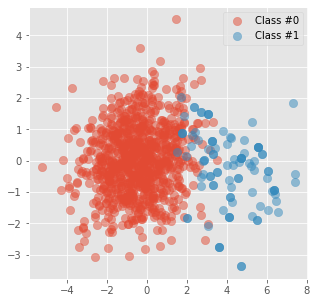

Target percentage 0.2
y.shape =  1125 y.mean() =  0.2


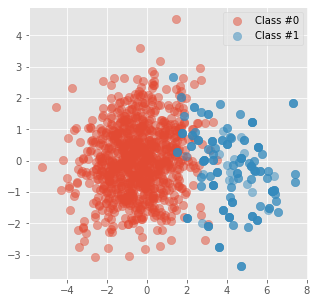

Target percentage 0.3
y.shape =  1285 y.mean() =  0.29961089494163423


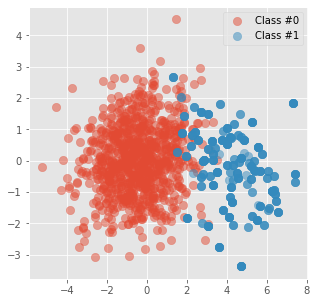

Target percentage 0.4
y.shape =  1500 y.mean() =  0.4


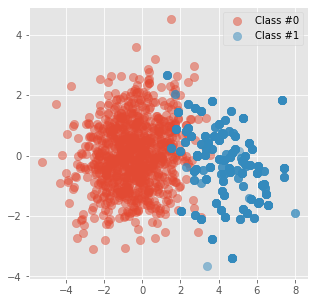

Target percentage 0.5
y.shape =  1800 y.mean() =  0.5


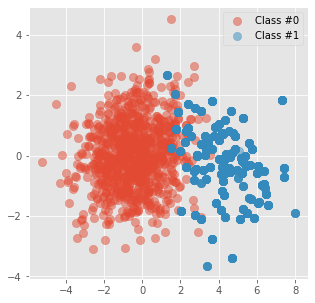

In [34]:
for target_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
    X_u, y_u = OverSampling(x_vis, y, target_percentage, 1)
    print('Target percentage', target_percentage)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()    

### Comparación del sobremuestreo con otros modelos

**Ventajas del sobremuestreo :**

- Rápido de estimar
- Fácil de entender
- No se pierde información de la clase mayoritaria

**Desventajas del sobremuestreo :**

- No se añade información nueva
- Perjudica la capacidad de generalización
- Varianza debida a la aleatoriedad 
- Necesidad de definir el porcentaje objetivo

## SMOTE

SMOTE (Chawla et. al. 2002) es un conocido algoritmo para combatir este problema. La idea general de este método es generar artificialmente nuevos ejemplos de la clase minoritaria utilizando los vecinos más cercanos de estos casos. Además, los ejemplos de la clase mayoritaria también son submuestreados, lo que da lugar a un conjunto de datos más equilibrado.

In [35]:
# Número de vecinos más cercanos que se utilizan para construir muestras sintéticas.
k = 5

from sklearn.neighbors import NearestNeighbors
nearest_neighbour_ = NearestNeighbors(n_neighbors=k + 1)

In [36]:
# Busca los k-ésimo vecinos más cercanos, excluyendo, por supuesto, el propio punto.
nearest_neighbour_.fit(x_vis[y==1])

NearestNeighbors(n_neighbors=6)

In [37]:
# Matriz con los índices de k-ésimo vecinos más cercanos para cada elemento minoritario.
nns = nearest_neighbour_.kneighbors(x_vis[y==1], 
                                    return_distance=False)[:, 1:]

Ejemplo de los nns de dos casos

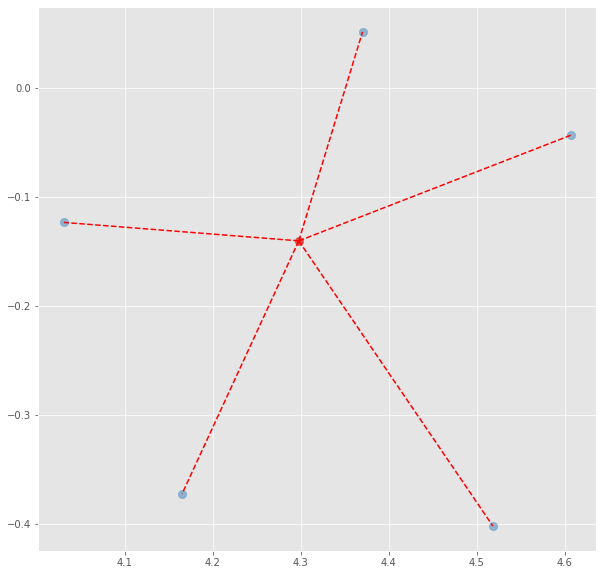

In [38]:

def base_smote_plot(sel, nns):
    fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    for i in range(len(sel)):
        # trazar la muestra seleccionada
        subplot.scatter(x_vis[y==1, 0][sel[i]], x_vis[y==1, 1][sel[i]],
                alpha=1., s=70)
        # trazar los vecinos
        subplot.scatter(x_vis[y==1, 0][nns[sel[i]]], 
                        x_vis[y==1, 1][nns[sel[i]]],
                        alpha=0.5, s=70) 
        
        # trazar las líneas
        for nn in nns[sel[i]]:
            plt.plot([x_vis[y==1, 0][sel[i]], x_vis[y==1, 0][nn]],  
                     [x_vis[y==1, 1][sel[i]], x_vis[y==1, 1][nn]],
                     'r--') 
    
    xlim = subplot.get_xlim()
    ylim = subplot.get_ylim()
    subplot.scatter(x_vis[y==1, 0], x_vis[y==1, 1], alpha=0.1, s=70)
    subplot.set_xlim(xlim)
    subplot.set_ylim(ylim)
    return subplot
base_smote_plot([12],nns)

In [39]:
# Crear una muestra sintética para 12

# Seleccionar un vecino al azar
np.random.seed(3)
nn_ = np.random.choice(nns[12])

x_vis[y==1][nn_]

array([ 4.03084442, -0.12359628])

In [40]:
# Dar un paso de tamaño aleatorio (0,1) en la dirección de los n vecinos más cercanos
np.random.seed(5)
step = np.random.uniform()

# Construir una muestra sintética
new = x_vis[y==1][12] - step * (x_vis[y==1][12] - x_vis[y==1][nn_])
new

array([ 4.23850327, -0.13675916])

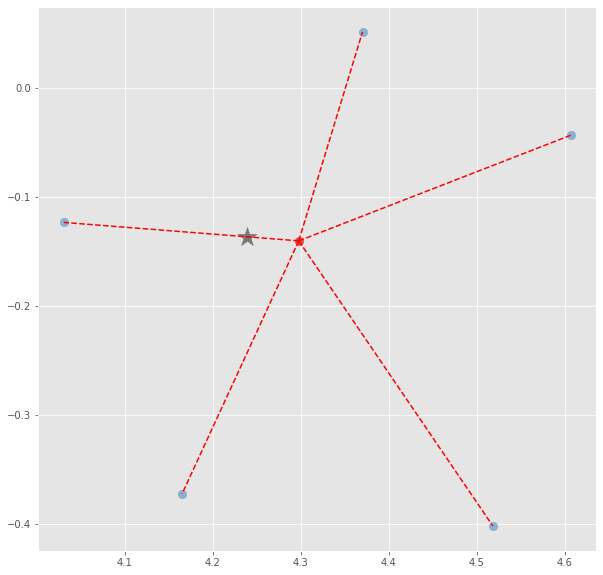

In [41]:
plot_ = base_smote_plot([12],nns)
plot_.scatter(new[0], new[1], alpha=1., s=400, marker="*")

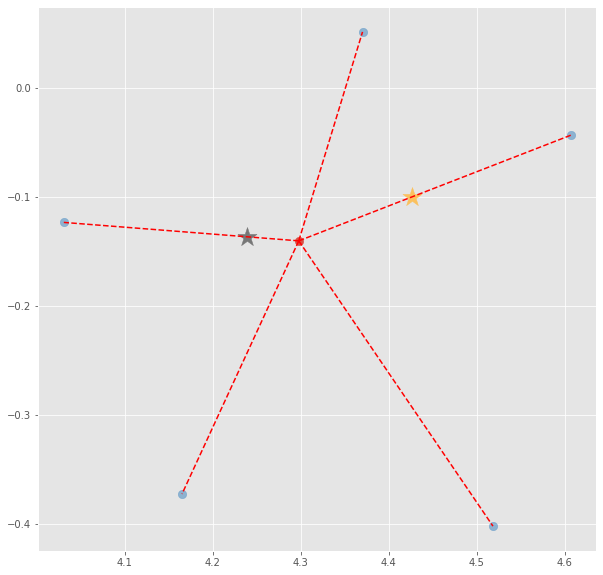

In [42]:
# Selecciona un vecino al azar
np.random.seed(5)
nn_2 = np.random.choice(nns[12])
np.random.seed(1)
step = np.random.uniform()
# Construir una muestra sintética
new2 = x_vis[y==1][12] - step * (x_vis[y==1][12] - x_vis[y==1][nn_2])

plot_ = base_smote_plot([12],nns)
plot_.scatter(new[0], new[1], alpha=1., s=400, marker="*")
plot_.scatter(new2[0], new2[1], alpha=1., s=400, marker="*")

Aplicar a todos los casos

Estimar el número de casos sintéticos a crear

In [43]:
target_percentage = 0.5
n_samples_1_new =  -target_percentage * n_samples_0 / (target_percentage- 1) - n_samples_1
n_samples_1_new = int(n_samples_1_new)
n_samples_1_new

800

In [44]:
# Una matriz para almacenar las muestras sintéticas
new = np.zeros((n_samples_1_new, x_vis.shape[1]))

In [45]:
# Seleccione los ejemplos a utilizar como base
np.random.seed(34)
sel_ = np.random.choice(y[y==1].shape[0], n_samples_1_new)

In [46]:
# Número de vecinos
K=5 
# Busca los k-ésimo vecinos más cercanos, excluyendo, por supuesto, el propio punto.
nearest_neighbour_ = NearestNeighbors(n_neighbors=k + 1)
nearest_neighbour_.fit(x_vis[y==1])
# Matriz con los índices de k-ésimo vecinos más cercanos para cada elemento minoritario.
nns = nearest_neighbour_.kneighbors(x_vis[y==1], 
                                    return_distance=False)[:, 1:]

# Selecciona un vecino al azar para cada ejemplo para usarlo como base
nn__=[]
np.random.seed(64)
for i, sel in enumerate(sel_):
    nn__.append(np.random.choice(nns[sel]))
        
np.random.seed(65)
steps = np.random.uniform(size=n_samples_1_new)

In [47]:
# Para cada uno de los ejemplos seleccionados crear un caso sintético
for i, sel in enumerate(sel_):
    # Seleccione el vecino
    nn_ = nn__[i]
    step = steps[i]
    new[i, :] = x_vis[y==1][sel] - step * (x_vis[y==1][sel] - x_vis[y==1][nn_])

In [48]:
new

array([[ 2.94509353, -2.15191299],
       [ 5.22078663, -0.57406517],
       [ 3.37867856, -2.53915492],
       ...,
       [ 3.2734085 ,  1.71527532],
       [ 4.08878791, -0.4008391 ],
       [ 2.81759291, -0.46752961]])

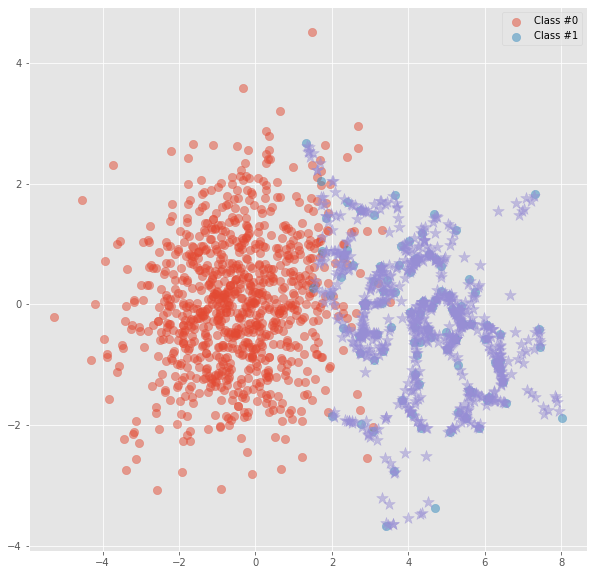

In [49]:
plot_ = plot_two_classes(x_vis, y, size=(10, 10))
plot_.scatter(new[:, 0], new[:, 1], alpha=0.5, s=150, marker='*')

Crear función

In [50]:
def SMOTE(X, y, target_percentage=0.5, k=5, seed=None):
    # Calcula los NearestNeighbors
    from sklearn.neighbors import NearestNeighbors
    nearest_neighbour_ = NearestNeighbors(n_neighbors=k + 1)
    nearest_neighbour_.fit(X[y==1])
    nns = nearest_neighbour_.kneighbors(X[y==1], 
                                    return_distance=False)[:, 1:]
    
    # Nuevas muestras
    n_samples_1_new =  int(-target_percentage * n_samples_0 / (target_percentage- 1) - n_samples_1)
    
    # Una matriz para almacenar las muestras sintéticas
    new = np.zeros((n_samples_1_new, X.shape[1]))
    
    # Crear semillas
    np.random.seed(seed)
    seeds = np.random.randint(1, 1000000, 3)
    
    # Seleccione los ejemplos a utilizar como base
    np.random.seed(seeds[0])
    sel_ = np.random.choice(y[y==1].shape[0], n_samples_1_new)
    
    # Definir semillas aleatorias (2 por ejemplo)
    np.random.seed(seeds[1])
    nn__=[]
    # Selecciona un vecino al azar para cada ejemplo para usarlo como base
    for i, sel in enumerate(sel_):
        nn__.append(np.random.choice(nns[sel]))
    
    np.random.seed(seeds[2])
    steps = np.random.uniform(size=n_samples_1_new)  

    # Para cada uno de los ejemplos seleccionados crear un caso sintético
    for i, sel in enumerate(sel_):
        # Seleccione el vecino
        nn_ = nn__[i]
        step = steps[i]
        # Crear una nueva muestra
        new[i, :] = X[y==1][sel] - step * (X[y==1][sel] - X[y==1][nn_])
    
    X = np.vstack((X, new))
    y = np.append(y, np.ones(n_samples_1_new))
    
    return X, y

Target percentage 0.25 k  5
y.shape =  1200 y.mean() =  0.25


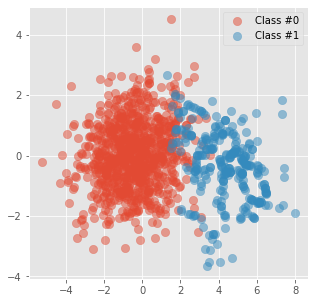

Target percentage 0.25 k  15
y.shape =  1200 y.mean() =  0.25


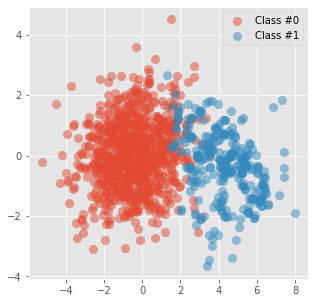

Target percentage 0.5 k  5
y.shape =  1800 y.mean() =  0.5


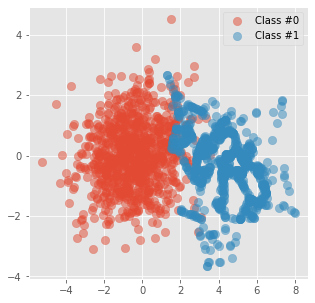

Target percentage 0.5 k  15
y.shape =  1800 y.mean() =  0.5


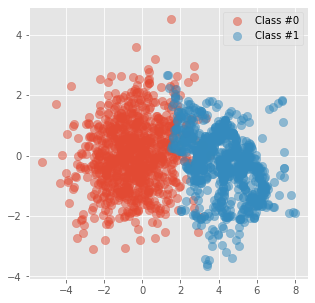

In [51]:
for target_percentage in [0.25, 0.5]:
    for k in [5, 15]:
        X_u, y_u = SMOTE(x_vis, y, target_percentage, k, seed=3)
        print('Target percentage', target_percentage, 'k ', k)
        print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
        plot_two_classes(X_u, y_u, size=(5, 5))
        plt.show()    


### Comparación de SMOTE con otros modelos

**Ventajas de SMOTE :**

- Permite la generalización
- Añade nueva información
- No se pierde información de la clase mayoritaria

**Desventajas de SMOTE :**

- **Varianza debida a la aleatoriedad** 
- Necesidad de definir el porcentaje objetivo y k
- No se crea ningún ejemplo sintético fuera del casco convexo

## Otras técnicas de sobremuestreo

* bSMOTE(1&2) - SMOTE de frontera de los tipos 1 y 2
* SVM_SMOTE - SMOTE de vectores de apoyo